## Load Dependencies

In [1]:
!pip install face_recognition
!pip install opencv-python
!pip install CMake
!pip install pillow
!pip install dlib
!pip install scipy
!pip install numba
!pip install numpy
!pip install tensorflow-gpu
!pip install keras
!pip install imageio
!pip install pandas
!pip install livelossplot
!pip install sklearn

import face_recognition
import cv2
import imageio
import scipy.misc
from scipy.stats import uniform  # for training-and-test split
import sys
from numba import vectorize
import numpy as np
import sys
import inspect
import face_recognition
import scipy.misc
from scipy import misc
import pandas as pd  # data frame operations
import numpy as np #arrays and math functions
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from livelossplot import PlotLossesKeras
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle
!pip install h5py
try:
  import h5py
except ImportError:
    h5py = None
    
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_yaml
from keras.models import model_from_json
import numpy
import os



def load_images(location):
    import sys
    import os
    paths_to_images = []
    face_encodings = [] 
    """
    Loads a set of images from a working directory
    :returns 128d facial encoding for each picture
    """
    image_filenames = sorted(filter(lambda x: x.endswith('.PNG') or \
                                    x.endswith('.png') or x.endswith('.jpg'), os.listdir(location))) #location = directory
    paths_to_images = [location + x for x in image_filenames] #location = directory

    def load_image_file(file): 
        """
        Loads an image file (.jpg, .png, etc) into a numpy array
        :return: image contents as numpy array
        numpy array converted from BGR to RGB for Facerec Library
        """
        file = cv2.imread(file)
        return cv2.cvtColor(file, cv2.COLOR_BGR2RGB)
    
    for path_to_image in paths_to_images:
        path_to_image = load_image_file(path_to_image)
        face_encodings.append(face_recognition.face_encodings(path_to_image)[0])
    known_face_encodings = face_encodings

        
    return(known_face_encodings)


def known_face_names(location):
    import sys
    import os
    image_filenames = sorted(filter(lambda x: x.endswith('.PNG') or x.endswith('.jpg')\
                                    or x.endswith('.png'), os.listdir(location))) #location = directory
    paths_to_images = [location + x for x in image_filenames] #location = directory
    return(paths_to_images)

    



C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Need to convert to .py file.

- Run cd Directory 

- run ipython filename.py


## Model Based, Rather than instance based

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13446642358047720282, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4932907827
 locality {
   bus_id: 1
 }
 incarnation: 3807952177812140400
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:02:00.0, compute capability: 6.1"]

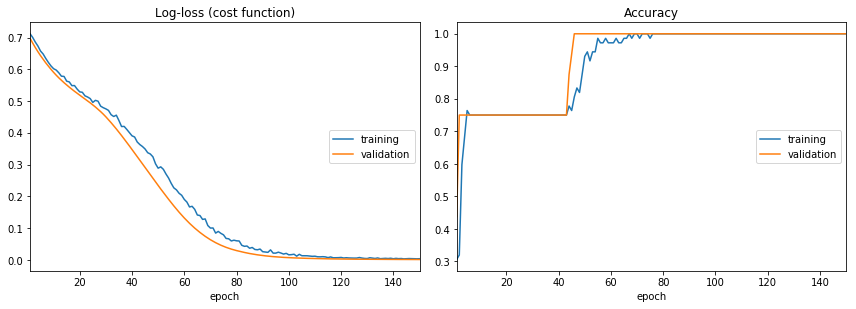

Saved model to disk


In [3]:
############################################Prepare Data######################################################################

#UDFs to create arrays of knownfaceencodings and knownfacenames
known_face_encodings = load_images(location = '3ClassTraining/')
known = pd.DataFrame(known_face_names(location = '3ClassTraining/'))


#Here is logic to define class based on filepath name. If path == "Jake" then 1, etc..
known.rename(columns={0 : 'Label'}, inplace=True)
known.loc[:,'Class'] = np.where(known["Label"].str.contains("JakeDineen"), "1",
                                np.where(known["Label"].str.contains("Vincent|Jewell|Bailee|Dave"), "0", "null"))


#len(known_face_encodings)
#Jake = pd.DataFrame(np.repeat(1, 30))
#NotJake = pd.DataFrame(np.repeat(0,52))
#y = [Jake, NotJake]
#y = pd.DataFrame(pd.concat(y))
#y = y.reset_index()
#y = y.drop("index", axis = 1)
#y.rename(columns={'0' : 'Label'}, inplace=True)



#Convert/Normalize Input Arrays
x = pd.DataFrame(known_face_encodings) #store as dataframe
x= x.astype('float32') #convert datatype to float 32

#Convert/O.H.E Input Arrays
num_classes = 2
y = pd.DataFrame(known.loc[:,'Class']) #Dependent Variable storage
y = np_utils.to_categorical(y,num_classes)

#Set Test Size to 0.4 after realizing initial success at a .2 threshold.
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=42)


############################################BUILD THE MODEL######################################################################

model = Sequential() #Prime the model
model.add(Dense(512, input_shape=(128,)))#shape from reshaped vector
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes)) #2 class output
model.add(Activation('softmax')) 

#Model parameters. 
NB_EPOCH = 150
#NB_EPOCH = 50
BATCH_SIZE = 75
VERBOSE = 1 #This sets Verbose to true meaning that logging output will be displayed on screen. Verbose = 0 is default and does allow model to run faster.
NB_CLASSES = num_classes
OPTIMIZER = Adam(lr= .0001)
VALIDATION_SPLIT = .3
Loss = 'binary_crossentropy'

with tf.device('/gpu:0'):
    model.compile(loss = Loss, optimizer= OPTIMIZER, metrics=['accuracy'])
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
    history = model.fit(xtrain, ytrain, batch_size= BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE,\
                            validation_split= VALIDATION_SPLIT, callbacks=[PlotLossesKeras()])

#################################################SAVE THE MODEL#################################################################
    
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [4]:
from sklearn.metrics import confusion_matrix
score = model.evaluate(xtest, ytest, verbose=VERBOSE)
print("Accuracy on test set =", score[1])

predicted = model.predict_classes(xtest)


# Predict the values from the validation dataset
Y_pred = model.predict(xtest)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(ytest,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
confusion_mtx




26/26 [==============================] - 0s 58us/step
Accuracy on test set = 1.0


array([[22,  0],
       [ 0,  4]], dtype=int64)

In [6]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

#known_face_encodings = load_images(location = '3ClassTraining/')
#known = known_face_names(location = '3ClassTraining/')


video_capture = cv2.VideoCapture(0)

# Initialize some variables
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True

while True:
    # Grab a single frame of video
    ret, frame = video_capture.read(0)

    # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    
    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_small_frame = small_frame[:, :, ::-1]

    # Only process every other frame of video to save time
    if process_this_frame:
        # Find all the faces and face encodings in the current frame of video
        face_locations = face_recognition.face_locations(rgb_small_frame)
        face_encodings = pd.DataFrame(face_recognition.face_encodings(rgb_small_frame, face_locations))

    face_names = []
    face_probs = []

    for face_encoding in face_encodings:
        # See if the face is a match for the known face(s)
        match = np.array(loaded_model.predict_classes(face_encodings))
        maxi = loaded_model.predict_proba(face_encodings)
        
        
        name = None
        if match ==0:
            name = "NotJake"
        elif match ==1:
            name = "Jake"          
        else:
            name = "Unknown"
            
        probs = str(np.round((maxi*100),2)) 
   
            
    
        face_names.append(name)
        face_probs.append(probs)
        process_this_frame = not process_this_frame

    # Display the results
    for (top, right, bottom, left), name, proba in zip(face_locations, face_names, face_probs):
        # Scale back up face locations since the frame we detected in was scaled to 1/4 siz
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4
        # Draw a box around the face
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

        # Draw a label with a name below the face
        cv2.rectangle(frame, (left, bottom), (right, bottom), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, name, (left + 50, bottom), font, 1.0, (255, 255, 255), 1)
        
        # Draw a label with softmax output on top of the bounding box and centered.q
        cv2.putText(frame, proba, (right - 125, top), font, .5, (255, 255, 255), 1)        
        
        


    # Display the resulting image
    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release handle to the webcam
video_capture.release()
cv2.destroyAllWindows()

Loaded model from disk


- Connect This to a Raspi + Pi Camera
- Tap into August API to unlock Door